## 0. Import Libraries

In [1]:
from glob import glob
from metpy.units import units

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

## 1. Parameters

In [2]:
# CHANGE BELOW!
# variable name
name_var = 't2m'

# ----------------------
# general path
path_general = 'data'

# data path
path_data = glob(fr'{path_general}/{name_var}*')[0]

# units to convert
unit_convert = {
    't2m':'degC',
    'blh':'m',
    'cbh':'m',
    'tp':'mm'
}

In [3]:
path_data

'data/t2m_era5_2001_2020.nc'

## 2. Open Data

In [4]:
# find datasets using glob
dt_era5 = xr.open_dataset(path_data)[name_var]

# assign units
dt_era5 = dt_era5 * units(dt_era5.attrs['units'])

In [5]:
dt_era5

<xarray.DataArray 't2m' (time: 44160, latitude: 33, longitude: 85)>
<Quantity([[[287.3968  288.24664 288.51572 ... 278.39072 279.76382 279.66455]
  [286.98114 288.68362 289.41287 ... 273.2331  275.31693 275.72516]
  [287.93954 289.91483 291.0198  ... 271.27826 271.78946 273.61536]
  ...
  [294.9926  295.1179  295.29507 ... 287.66028 285.91232 286.56454]
  [293.00064 293.34857 293.91083 ... 289.93988 289.29504 290.35367]
  [295.22736 294.77182 294.76624 ... 291.4401  291.1998  293.1955 ]]

 [[287.25113 288.10654 288.49716 ... 278.0363  279.4892  279.44467]
  [286.82526 287.79016 288.0852  ... 273.10507 274.8586  275.02283]
  [287.68906 288.32922 288.36633 ... 271.33948 271.40723 273.01694]
  ...
  [294.80798 294.95087 295.18097 ... 287.19452 285.32782 285.20813]
  [292.83087 293.2493  293.92474 ... 290.7183  288.95084 289.18094]
  [294.92676 294.42667 294.68274 ... 291.19888 290.68674 291.89935]]

 [[286.9626  287.7614  288.2049  ... 278.20514 279.6126  279.81857]
  [286.29828 286.82434 287.81058 ... 273.3806  275.11652 275.39578]
  [287.14813 287.50998 288.2884  ... 271.7709  271.87482 273.3964 ]
  ...
...
  ...
  [299.34674 299.25305 299.4516  ... 298.60452 297.686   296.89737]
  [296.34534 296.96417 297.8892  ... 298.7511  299.00348 299.80417]
  [298.66296 299.38943 299.53418 ... 303.6749  302.87793 299.99435]]

 [[292.14523 292.20554 292.29276 ... 286.53394 286.67404 285.20718]
  [291.52176 291.377   291.90863 ... 280.6898  281.7521  281.57303]
  [292.29276 292.5822  293.70483 ... 278.9279  278.92606 279.80838]
  ...
  [299.35974 299.30316 299.51932 ... 296.44925 295.5159  294.6076 ]
  [295.47043 296.0002  297.0115  ... 296.93542 297.1451  297.88828]
  [297.74445 298.20465 298.70752 ... 301.90283 300.873   297.28705]]

 [[290.8751  291.09775 291.30466 ... 286.3864  286.302   285.16638]
  [290.99942 290.6719  291.2462  ... 280.828   281.84396 281.74097]
  [292.3512  292.18512 293.11478 ... 279.12552 279.1654  280.0097 ]
  ...
  [299.40244 299.3477  299.60745 ... 295.23663 294.2439  293.28085]
  [295.21344 295.75156 296.85748 ... 295.6829  295.71167 296.27762]
  [297.2824  297.62662 298.22043 ... 300.2699  298.58783 295.54282]]], 'kelvin')>
Coordinates:
  * longitude  (longitude) float32 25.0 25.25 25.5 25.75 ... 45.5 45.75 46.0
  * latitude   (latitude) float32 43.0 42.75 42.5 42.25 ... 35.5 35.25 35.0
  * time       (time) datetime64[ns] 2001-06-01 ... 2020-08-31T23:00:00

## 3. Aggregation

In [6]:
# for month-hour agg
dt_era5.coords['monthhour'] = (
    ('time', ),
    pd.MultiIndex.from_arrays([dt_era5.time.dt.month.values, dt_era5.time.dt.hour.values])
                             )

In [6]:
# for month-hour agg
dt_era5.coords['yearhour'] = (
    ('time', ),
    pd.MultiIndex.from_arrays([dt_era5.time.dt.year.values, dt_era5.time.dt.hour.values])
                             )

### 3.1 Month-Hourly

In [ ]:
# agg type
type1 = 'month'
type2 = 'hour'
type_agg = type1 + type2

# unit conversion
# group by hour of each month
# unstack e.g., 72 to (3, 24) --> 3 months 24 hours..

# sum for tp
if name_var == 'tp':
    dt_agg = dt_era5.metpy\
                        .convert_units(unit_convert[name_var])\
                        .groupby(type_agg)\
                        .sum(dim='time')\
                        .unstack({type_agg})\
                        .rename({fr'{type_agg}_level_0':type1,
                                 fr'{type_agg}_level_1':type2})\
                        .transpose(type1, type2, 'latitude', 'longitude')
    
# mean for others
else:
    dt_agg = dt_era5.metpy\
                        .convert_units(unit_convert[name_var])\
                        .groupby(type_agg)\
                        .mean(dim='time')\
                        .unstack({type_agg})\
                        .rename({fr'{type_agg}_level_0':type1,
                                 fr'{type_agg}_level_1':type2})\
                        .transpose(type1, type2, 'latitude', 'longitude')

# save to netcdf file
dt_agg.to_netcdf(fr'{path_general}/aggregated_{name_var}_era5_{type_agg}')

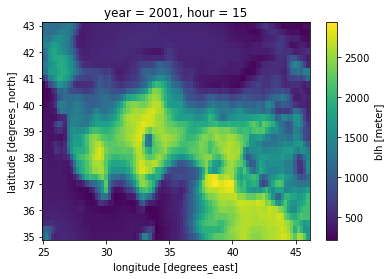

In [11]:
dt_agg[0][15].plot()

### 3.2 Year-Hourly Sum

In [7]:
# agg type
type1 = 'year'
type2 = 'hour'
type_agg = type1 + type2

# unit conversion
# group by hour of each year
# unstack e.g., 480 to (20, 24) --> 20 years 24 hours..

# sum for tp
if name_var == 'tp':
    dt_agg = dt_era5.metpy\
                        .convert_units(unit_convert[name_var])\
                        .groupby(type_agg)\
                        .sum(dim='time')\
                        .unstack({type_agg})\
                        .rename({fr'{type_agg}_level_0':type1,
                                 fr'{type_agg}_level_1':type2})\
                        .transpose(type1, type2, 'latitude', 'longitude')
    
# mean for others
else:
    dt_agg = dt_era5.metpy\
                        .convert_units(unit_convert[name_var])\
                        .groupby(type_agg)\
                        .mean(dim='time')\
                        .unstack({type_agg})\
                        .rename({fr'{type_agg}_level_0':type1,
                                 fr'{type_agg}_level_1':type2})\
                        .transpose(type1, type2, 'latitude', 'longitude')

# save to netcdf file
dt_agg.to_netcdf(fr'{path_general}/aggregated_{name_var}_era5_{type_agg}')

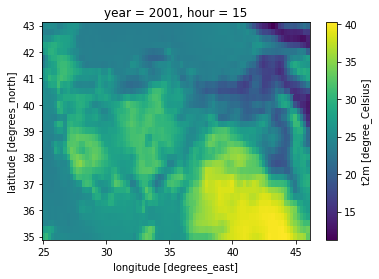

In [8]:
dt_agg[0][15].plot()